In [85]:
import numpy as np
import cv2
import os
from skimage.filters.rank import entropy
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

#  Phase 1: Feature Extraction

## Load Images from Dataset
This function loads images, resizes them, and stores them in arrays.

In [86]:
def load_images(folder, img_size=(256, 256)):
    images = []
    labels = []
    for class_name in os.listdir(folder):
        class_path = os.path.join(folder, class_name)
        if os.path.isdir(class_path):
            for img_name in os.listdir(class_path):
                img_path = os.path.join(class_path, img_name)
                img = cv2.imread(img_path)
                img = cv2.resize(img, img_size)
                images.append(img)
                labels.append(class_name)
    return np.array(images), np.array(labels)

## Feature Extraction
The following function extracts various features including color, texture, edge density, and statistical properties.


In [113]:
import cv2
import numpy as np
from skimage.feature import graycomatrix, graycoprops
from skimage.measure import shannon_entropy

def extract_features(images):
    """
    Extracts various features from images including color, texture, edge density, 
    statistical properties, and homogeneity.
    """
    features = []
    for img in images:
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # Color Features: Mean values of R, G, B channels
        mean_colors = img.mean(axis=(0, 1))

        # Texture Feature: Variance of Laplacian (sharpness measure)
        lbp = cv2.Laplacian(gray, cv2.CV_64F).var()

        # Edge Feature: Edge density using Canny edge detection
        edges = cv2.Canny(gray, 100, 200)
        edge_density = np.mean(edges)

        # Statistical Feature: Combined Mean & Variance of pixel intensity
        stat_features = np.mean(gray) + np.var(gray)

        # Color Variance: Measures the diversity of colors in the image
        color_variance = np.var(img, axis=(0, 1)).mean()

        # Improved Roughness: Standard deviation of intensity differences
        diff_intensity = np.diff(gray.astype(np.float32), axis=0)
        roughness = np.std(diff_intensity)

        # Image Entropy: Measures randomness/complexity in the image
        entropy_value = shannon_entropy(gray)

        # New Feature: GLCM Homogeneity (Texture Feature)
        glcm = graycomatrix(gray, distances=[1], angles=[0], levels=256, symmetric=True, normed=True)
        homogeneity = graycoprops(glcm, 'homogeneity')[0, 0]

        # Append features to the list
        features.append([
            *mean_colors, lbp, edge_density, stat_features,
            color_variance, roughness, entropy_value, homogeneity
        ])

    return np.array(features)


## Process Images and Save Features
Now, we load the images, extract features, and save them into a CSV file for further analysis.


In [114]:
import os
import pandas as pd

# Load images from dataset
image_folder = "./dataset/train"
images, labels = load_images(image_folder)

# Extract features
features = extract_features(images)

# Define feature names
feature_names = ["R", "G", "B", "LBP", "Edges", "Stat_Feature", "Color_Variance", "Roughness", "Entropy", "Homogeneity"]

# Save extracted features into a CSV file for further analysis
df = pd.DataFrame(features, columns=feature_names)

output_path = "features.csv"
df.to_csv(output_path, index=False)

print(f"✅ Feature extraction completed and saved to {output_path}!")


✅ Feature extraction completed and saved to features.csv!


## Summary of Extracted Features  

Below is a summary of all extracted features along with their descriptions:

|  **Feature Name** |  **Description** |
|--------------|-------------------------------------------------------------|
| **R, G, B** | Average pixel intensity in Red, Green, and Blue channels (color features) |
| **LBP (Laplacian Variance)** | Measures texture sharpness and contrast (higher = sharper texture) |
| **Edge Density** | Number of edges detected using the Canny edge detector (higher = more edges) |
| **Stat_Feature** | Combined Mean & Variance of pixel intensities (brightness & contrast) |
| **Color Variance** | Measures the diversity of colors in the image (higher = more colorful) |
| **Texture Roughness** | Measures surface roughness using pixel intensity differences (higher = rougher) |
| **Entropy** | Measures randomness & complexity in the image (higher = more complex texture) |

---
### ✅ **Key Insights**
✔ **Higher Edge Density** → More detailed images with strong contours.  
✔ **Higher Entropy** → More complex images with diverse textures.  
✔ **Higher Color Variance** → More colorful and vibrant images.  
✔ **Higher Roughness** → More irregular and noisy textures.  

These features will be used in the next step for **Feature Selection (Phase 2).**  
**Let’s move to the next step!**


#  Phase 2: Feature Selection

In [115]:
# Load extracted features from Phase 1
df = pd.read_csv("features.csv")

### Manually Calculate Pearson Correlation Coefficient

In [116]:
def pearson_correlation(x, y):
    mean_x, mean_y = sum(x) / len(x), sum(y) / len(y)
    numerator = sum((a - mean_x) * (b - mean_y) for a, b in zip(x, y))
    denominator = ((sum((a - mean_x) ** 2 for a in x) * sum((b - mean_y) ** 2 for b in y)) ** 0.5)
    return numerator / denominator if denominator != 0 else 0

### Construct Correlation Matrix

In [122]:
# Construct correlation matrix manually
features = df.columns[1:]
correlation_matrix = {}

for feature1 in features:
    correlation_matrix[feature1] = {}
    for feature2 in features:
        if feature1 == feature2:
            correlation_matrix[feature1][feature2] = 1  # Correlation with itself is always 1
        else:
            correlation_matrix[feature1][feature2] = pearson_correlation(df[feature1], df[feature2])

# Convert dictionary to DataFrame for better visualization
correlation_df = pd.DataFrame(correlation_matrix)

# Display correlation matrix
correlation_df


,G,B,LBP,Edges,Stat_Feature,Color_Variance,Roughness,Entropy,homogeneity
G,1.000000,0.965685,-0.081097,-0.333975,0.029814,0.002074,-0.190332,-0.036695,0.192892
B,0.965685,1.000000,-0.104274,-0.352835,-0.061720,-0.091258,-0.221311,-0.112155,0.195375
LBP,-0.081097,-0.104274,1.000000,0.662117,0.477751,0.482744,0.926014,0.623362,-0.522320
Edges,-0.333975,-0.352835,0.662117,1.000000,0.299933,0.309060,0.786167,0.660382,-0.755086
Stat_Feature,0.029814,-0.061720,0.477751,0.299933,1.000000,0.998197,0.564653,0.637138,-0.062877
Color_Variance,0.002074,-0.091258,0.482744,0.309060,0.998197,1.000000,0.571674,0.645493,-0.070635
Roughness,-0.190332,-0.221311,0.926014,0.786167,0.564653,0.571674,1.000000,0.748781,-0.608135
Entropy,-0.036695,-0.112155,0.623362,0.660382,0.637138,0.645493,0.748781,1.000000,-0.643319
homogeneity,0.192892,0.195375,-0.522320,-0.755086,-0.062877,-0.070635,-0.608135,-0.643319,1.000000


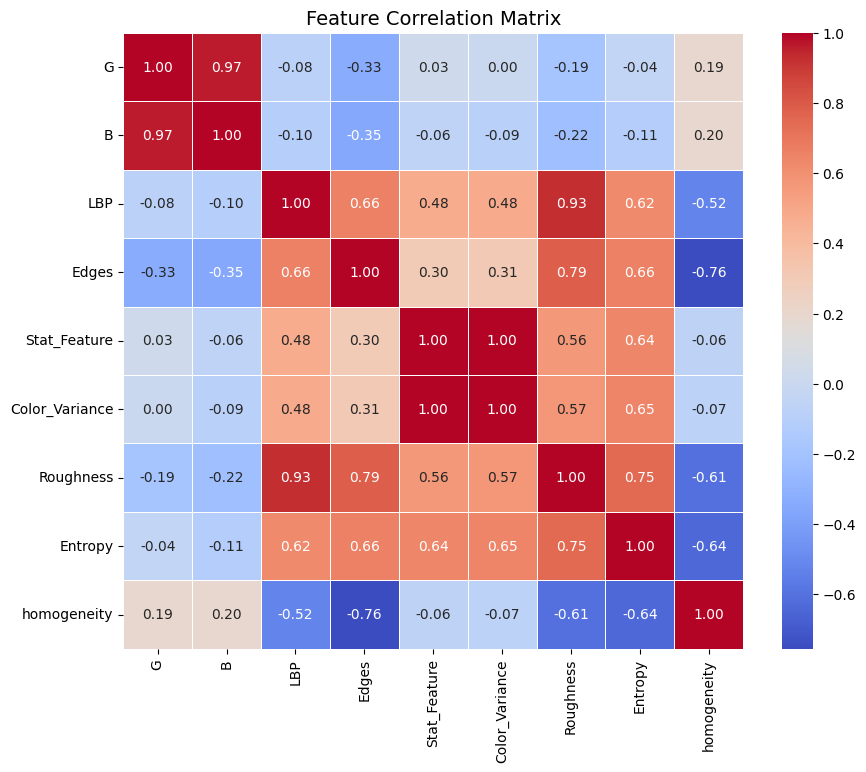

In [123]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Assuming correlation_df is correctly computed
# Now we plot the heatmap using correlation_df
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_df, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)

# Adding title
plt.title("Feature Correlation Matrix", fontsize=14)

# Show the plot
plt.show()


### Remove Highly Correlated Features

In [125]:
# Define a threshold to remove highly correlated features
threshold = 0.91
features_to_remove = set()

for feature1 in features:
    for feature2 in features:
        if feature1 != feature2 and abs(correlation_matrix[feature1][feature2]) > threshold:
            features_to_remove.add(feature2)  # Mark feature for removal

# Display features to be removed
print("Features to be removed:", features_to_remove)


Features to be removed: {'Color_Variance', 'B', 'Stat_Feature', 'LBP', 'Roughness', 'G'}


### Select Final Features

In [44]:
df

,R,G,B,LBP,Edges,Stat_Feature,Color_Variance,Roughness,Entropy
0,111.283813,114.904465,108.790283,1364.888759,30.731049,3274.770846,3209.058286,9.319777,2.773008
1,81.355408,98.349182,91.633728,1484.439259,37.369080,2153.253050,1984.181087,9.188955,2.830071
2,116.525467,115.214539,101.966843,205.893287,12.225494,2897.296742,2740.012085,4.105699,2.055768
3,134.168777,156.773071,158.563782,1007.881371,22.143631,2178.887335,2078.209883,8.012745,2.684014
4,88.738983,92.399643,62.134338,301.154404,9.778061,843.837975,778.550681,5.211122,2.631159
...,...,...,...,...,...,...,...,...,...
3595,64.048111,64.174866,49.144882,392.195829,30.439224,1349.319304,1272.178002,6.918444,2.726147
3596,95.026627,90.493500,83.907715,576.124731,33.789368,1340.310007,1257.839791,7.143306,2.761129
3597,69.078217,65.181244,65.378235,460.373184,41.197815,1933.901735,1874.987938,8.455209,2.648527
3598,54.184723,56.238480,39.600189,236.444987,10.295563,3301.924794,3203.362395,3.889216,1.553199


In [126]:
# Select the final features by removing highly correlated ones
selected_features = [f for f in features if f not in features_to_remove]

# Select the final features by removing highly correlated ones
df_selected = df[selected_features]

# Save the selected features to a new CSV file
df_selected.to_csv("features_selected.csv", index=False)

# Display selected features
print("Selected Features:", selected_features)


Selected Features: ['Edges', 'Entropy', 'homogeneity']


### Verifying the Accuracy of the Manual Algorithm
This section compares the manually computed correlation-based feature selection with the built-in Pandas functions to ensure correctness.


In [128]:
import pandas as pd

# Load extracted features
df = pd.read_csv("features.csv")

# Compute correlation matrix using Pandas
correlation_matrix = df.corr()

# Define a threshold for high correlation
threshold = 0.91

# Identify highly correlated features
to_remove = set()
for col in correlation_matrix.columns:
    for row in correlation_matrix.index:
        if col != row and abs(correlation_matrix.loc[row, col]) > threshold:
            to_remove.add(row)

# Select features that are not highly correlated
selected_features_lib = [f for f in df.columns if f not in to_remove]

# Create a new DataFrame with selected features
df_selected_lib = df[selected_features_lib]

# Save the selected features
df_selected_lib.to_csv("features_selected_lib.csv", index=False)

# Display results
print("Selected Features using Pandas:", selected_features_lib)


Selected Features using Pandas: ['Edges', 'Entropy', 'homogeneity']
